<a href="https://colab.research.google.com/github/Virushaba/DDoS-Attack-Detection-and-Mitigation/blob/main/hybrid_qkd_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid QKD + ML Notebook
This notebook integrates BB84+E91 QKD with ML attack detection.

#Trial with hybrid qkd

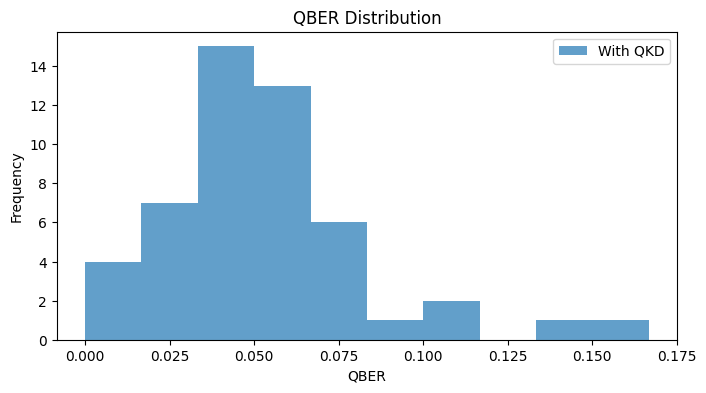

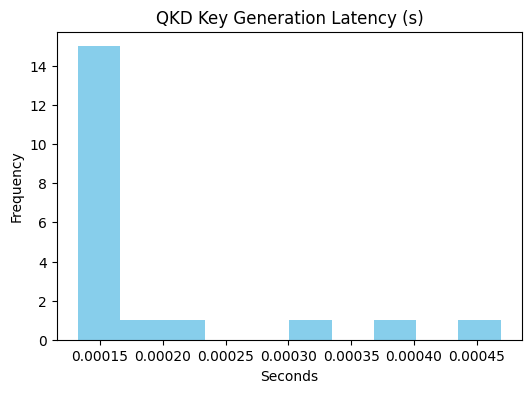

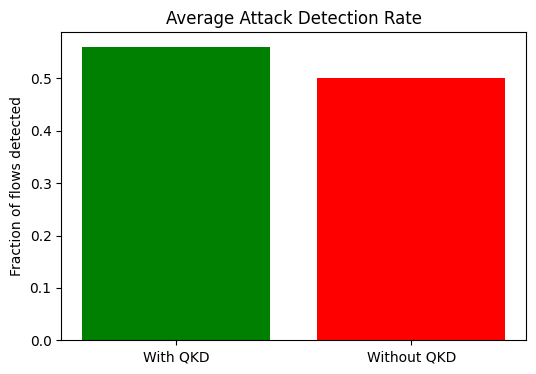

=== Evaluation: With QKD ===
Confusion Matrix:
 [[21  0  0  0  0  0]
 [ 1 12  0  0  1  1]
 [ 0  0  1  0  0  0]
 [ 0  0  0  7  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  5]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     1.0000    0.8000    0.8889        15
           2     1.0000    1.0000    1.0000         1
           3     1.0000    1.0000    1.0000         7
           4     0.5000    1.0000    0.6667         1
           5     0.8333    1.0000    0.9091         5

    accuracy                         0.9400        50
   macro avg     0.8813    0.9667    0.9069        50
weighted avg     0.9542    0.9400    0.9411        50



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


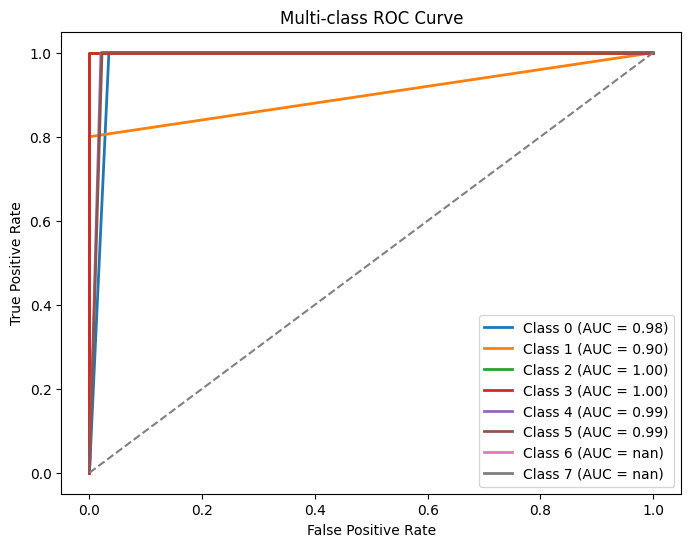

=== Evaluation: Without QKD ===
Confusion Matrix:
 [[25  0  0  0  0  0]
 [ 0 13  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0  3  0  0]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0  0  6]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        25
           1     1.0000    1.0000    1.0000        13
           2     1.0000    1.0000    1.0000         1
           3     1.0000    1.0000    1.0000         3
           4     1.0000    1.0000    1.0000         2
           5     1.0000    1.0000    1.0000         6

    accuracy                         1.0000        50
   macro avg     1.0000    1.0000    1.0000        50
weighted avg     1.0000    1.0000    1.0000        50



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


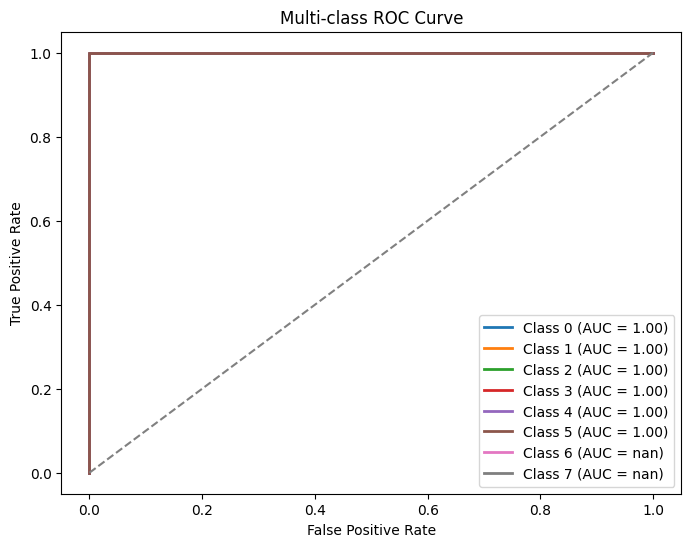


ROC-AUC Comparison Table:
    Class  ROC_AUC_With_QKD  ROC_AUC_Without_QKD
0      0          0.982759                  1.0
1      1          0.900000                  1.0
2      2          1.000000                  1.0
3      3          1.000000                  1.0
4      4          0.989796                  1.0
5      5          0.988889                  1.0
6      6               NaN                  NaN
7      7               NaN                  NaN


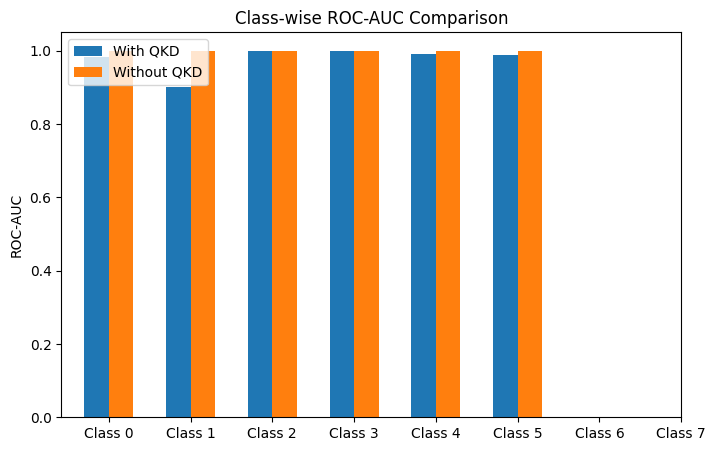

In [ ]:
# ------------------------------
# 0. Imports
# ------------------------------
import numpy as np
import pandas as pd
import random
import time
from collections import Counter
import matplotlib.pyplot as plt
import joblib
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import tensorflow as tf
from tensorflow.keras.models import load_model

# ------------------------------
# 1. Load pre-trained model, scaler, and test data
# ------------------------------
X_test = pd.read_csv('X_test.csv').values
y_test = pd.read_csv('y_test.csv').values

scaler = joblib.load('scaler_qkd.save')
X_test_scaled = scaler.transform(X_test)

# Define focal loss (needed to load custom model)
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        probs = tf.reduce_sum(y_true * y_pred, axis=1)
        focal = alpha * tf.pow((1. - probs), gamma) * cross_entropy
        return tf.reduce_mean(focal)
    return focal_loss_fixed

model = load_model('best_model.keras', compile=False)
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

# ------------------------------
# 2. Hybrid QKD Simulation (BB84 + E91)
# ------------------------------
def simulate_bb84_key(num_bits=128, eavesdrop_prob=0.1):
    alice_bits = np.random.randint(0,2,num_bits)
    alice_bases = np.random.randint(0,2,num_bits)
    bob_bases = np.random.randint(0,2,num_bits)
    intercepted = np.random.rand(num_bits) < eavesdrop_prob
    bob_bits = np.where(intercepted, np.random.randint(0,2,num_bits), alice_bits)
    key = alice_bits[alice_bases == bob_bases]
    qber = np.sum(key != bob_bits[alice_bases == bob_bases]) / max(len(key),1)
    return key, qber

def simulate_e91_key(num_bits=128):
    corr = np.random.rand()  # E91 correlation metric
    key = np.random.randint(0,2,num_bits)
    return key, corr

def hybrid_qkd_key(num_bits=128, eavesdrop_prob=0.1):
    key_bb84, qber = simulate_bb84_key(num_bits, eavesdrop_prob)
    key_e91, corr = simulate_e91_key(num_bits)
    min_len = min(len(key_bb84), len(key_e91))
    key = np.bitwise_xor(key_bb84[:min_len], key_e91[:min_len])
    return key, qber, corr

from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import hashlib

def aes_encrypt(key, message):
    # Convert numpy array to bytes
    key_bytes = key.tobytes() if isinstance(key, np.ndarray) else key.encode()
    # Hash to 32 bytes for AES-256
    key_hashed = hashlib.sha256(key_bytes).digest()

    cipher = AES.new(key_hashed, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(message.encode(), AES.block_size))
    return cipher.iv + ct_bytes  # prepend IV for decryption

def aes_decrypt(key, ciphertext):
    key_bytes = key.tobytes() if isinstance(key, np.ndarray) else key.encode()
    key_hashed = hashlib.sha256(key_bytes).digest()

    iv = ciphertext[:AES.block_size]
    ct = ciphertext[AES.block_size:]
    cipher = AES.new(key_hashed, AES.MODE_CBC, iv)
    pt = unpad(cipher.decrypt(ct), AES.block_size)
    return pt

'''
def aes_encrypt(key_bits, message):
    key_bytes = np.packbits(key_bits)[:16].tobytes()
    cipher = AES.new(key_bytes, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(message.encode(),16))
    return cipher.iv + ct_bytes

def aes_decrypt(key_bits, ciphertext):
    key_bytes = np.packbits(key_bits)[:16].tobytes()
    iv, ct = ciphertext[:16], ciphertext[16:]
    cipher = AES.new(key_bytes, AES.MODE_CBC, iv=iv)
    return unpad(cipher.decrypt(ct),16)'''

# ------------------------------
# 3. Flow-level ML + QKD integration test
# ------------------------------
def hybrid_qkd_integration_test(model, X_test, y_test, scaler, n_flows=50, use_qkd=True):
    results = []
    for _ in range(n_flows):
        idx = np.random.randint(0, len(X_test))
        flow_features, true_label = X_test[idx], y_test[idx]
        flow_scaled = scaler.transform(flow_features.reshape(1,-1))
        pred_probs = model.predict(flow_scaled.reshape(1,flow_scaled.shape[1],1), verbose=0)
        predicted_class = np.argmax(pred_probs, axis=1)[0]
        attack_detected = predicted_class != 0
        key, qber, corr = None, None, None
        if use_qkd:
            key, qber, corr = hybrid_qkd_key()
            msg = 'drop_flow' if attack_detected else 'allow_flow'
            ciphertext = aes_encrypt(key, msg)
            decrypted = aes_decrypt(key, ciphertext).decode()
        else:
            msg = 'drop_flow' if attack_detected else 'allow_flow'
            decrypted = msg
        results.append({
            'true_label': int(true_label.item()),
            'pred_class': int(predicted_class),
            'attack_detected': attack_detected,
            'qber': qber,
            'corr': corr,
            'message': decrypted
        })
    return pd.DataFrame(results)

# ------------------------------
# 4. Run comparative analysis
# ------------------------------
df_qkd = hybrid_qkd_integration_test(model, X_test, y_test, scaler, n_flows=50, use_qkd=True)
df_no_qkd = hybrid_qkd_integration_test(model, X_test, y_test, scaler, n_flows=50, use_qkd=False)

# QBER Distribution
plt.figure(figsize=(8,4))
plt.hist(df_qkd['qber'].dropna(), bins=10, alpha=0.7, label='With QKD')
plt.title('QBER Distribution')
plt.xlabel('QBER')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# ------------------------------
# 5. Latency Analysis
# ------------------------------
latencies = []
n_runs = 20
for _ in range(n_runs):
    start = time.time()
    hybrid_qkd_key()
    latencies.append(time.time()-start)

plt.figure(figsize=(6,4))
plt.hist(latencies, bins=10, color='skyblue')
plt.title('QKD Key Generation Latency (s)')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

# ------------------------------
# 6. Attack Detection Comparison
# ------------------------------
plt.figure(figsize=(6,4))
plt.bar(['With QKD','Without QKD'],
        [df_qkd['attack_detected'].mean(), df_no_qkd['attack_detected'].mean()],
        color=['green','red'])
plt.title('Average Attack Detection Rate')
plt.ylabel('Fraction of flows detected')
plt.show()


from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ------------------------------
# 7. Full Evaluation Metrics
# ------------------------------
def evaluate_detection(df, n_classes=8):
    y_true = df['true_label'].values
    y_pred = df['pred_class'].values
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0 ))

    # ROC/AUC
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(n_classes)))

    roc_auc_dict = {}
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_pred_bin[:,i])
        roc_auc = auc(fpr, tpr)
        roc_auc_dict[i] = roc_auc
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1], linestyle='--', color='grey')
    plt.title('Multi-class ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc_dict

# Evaluate WITH QKD
print("=== Evaluation: With QKD ===")
roc_auc_qkd = evaluate_detection(df_qkd)

# Evaluate WITHOUT QKD
print("=== Evaluation: Without QKD ===")
roc_auc_no_qkd = evaluate_detection(df_no_qkd)

# ------------------------------
# 8. Comparison summary
# ------------------------------
comparison_df = pd.DataFrame({
    'Class': list(range(8)),
    'ROC_AUC_With_QKD': [roc_auc_qkd[i] for i in range(8)],
    'ROC_AUC_Without_QKD': [roc_auc_no_qkd[i] for i in range(8)]
})
print("\nROC-AUC Comparison Table:\n", comparison_df)

# Optional bar plot for AUC comparison
plt.figure(figsize=(8,5))
plt.bar(np.arange(8)-0.15, comparison_df['ROC_AUC_With_QKD'], width=0.3, label='With QKD')
plt.bar(np.arange(8)+0.15, comparison_df['ROC_AUC_Without_QKD'], width=0.3, label='Without QKD')
plt.xticks(np.arange(8), labels=[f'Class {i}' for i in range(8)])
plt.ylabel('ROC-AUC')
plt.title('Class-wise ROC-AUC Comparison')
plt.legend()
plt.show()


# trial 2

Loading model, scaler, and test data...
✅ Model loaded.
Running integration tests...


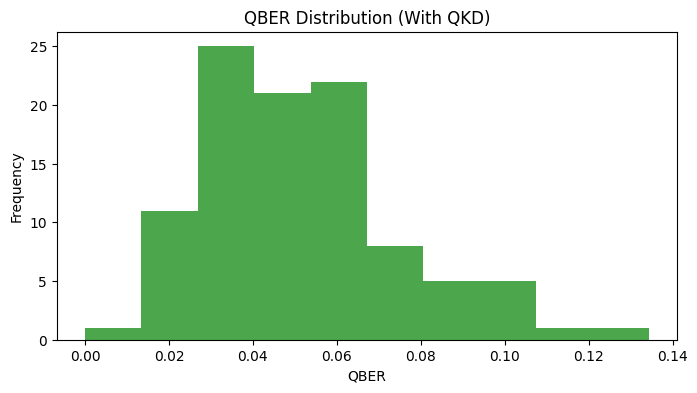

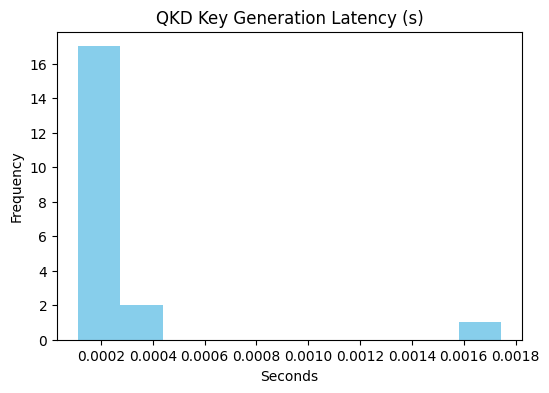

Batch of 1 flows -> Total key generation time: 0.0007 s, Avg per flow: 0.0007 s
Batch of 5 flows -> Total key generation time: 0.0017 s, Avg per flow: 0.0003 s
Batch of 10 flows -> Total key generation time: 0.0015 s, Avg per flow: 0.0001 s
Batch of 20 flows -> Total key generation time: 0.0023 s, Avg per flow: 0.0001 s
Batch of 50 flows -> Total key generation time: 0.0034 s, Avg per flow: 0.0001 s
Batch of 100 flows -> Total key generation time: 0.0066 s, Avg per flow: 0.0001 s


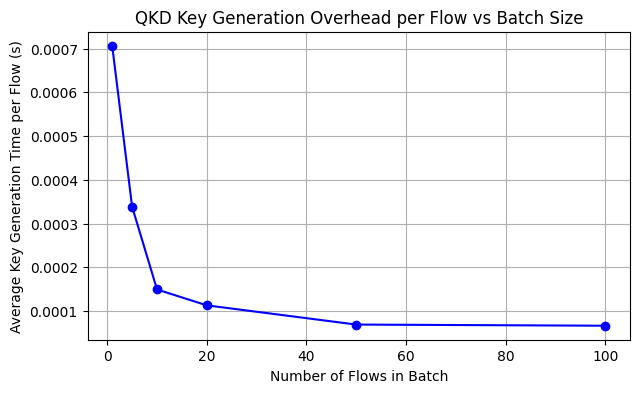

=== Evaluation: With QKD ===
Confusion Matrix:
 [[44  0  0  0  0  0  2]
 [ 0 18  0  0  1  1  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  0 17  0  0  0]
 [ 0  0  0  0  6  0  0]
 [ 0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9565    0.9778        46
           1     1.0000    0.9000    0.9474        20
           2     1.0000    1.0000    1.0000         2
           3     1.0000    1.0000    1.0000        17
           4     0.8571    1.0000    0.9231         6
           5     0.9000    1.0000    0.9474         9
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.9600       100
   macro avg     0.8224    0.8366    0.8279       100
weighted avg     0.9824    0.9600    0.9699       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


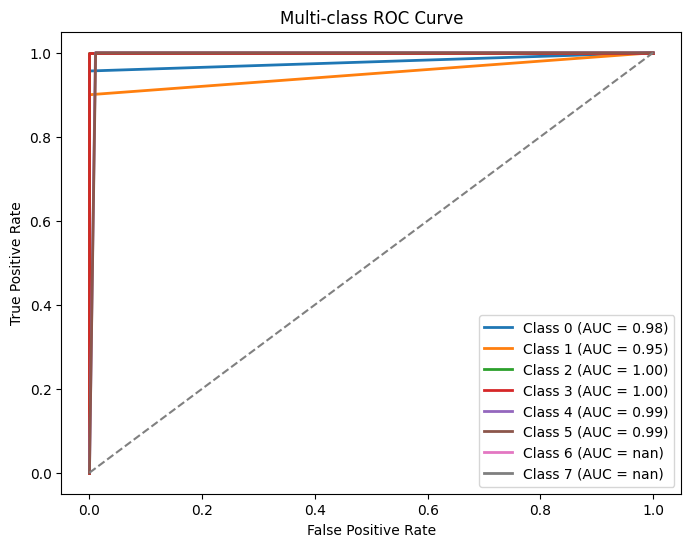

=== Evaluation: Without QKD ===
Confusion Matrix:
 [[53  0  0  0  0  0]
 [ 0 17  0  0  1  1]
 [ 0  0  1  0  0  0]
 [ 0  0  0 15  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  1 10]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        53
           1     1.0000    0.8947    0.9444        19
           2     1.0000    1.0000    1.0000         1
           3     1.0000    1.0000    1.0000        15
           4     0.3333    1.0000    0.5000         1
           5     0.9091    0.9091    0.9091        11

    accuracy                         0.9700       100
   macro avg     0.8737    0.9673    0.8923       100
weighted avg     0.9833    0.9700    0.9744       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


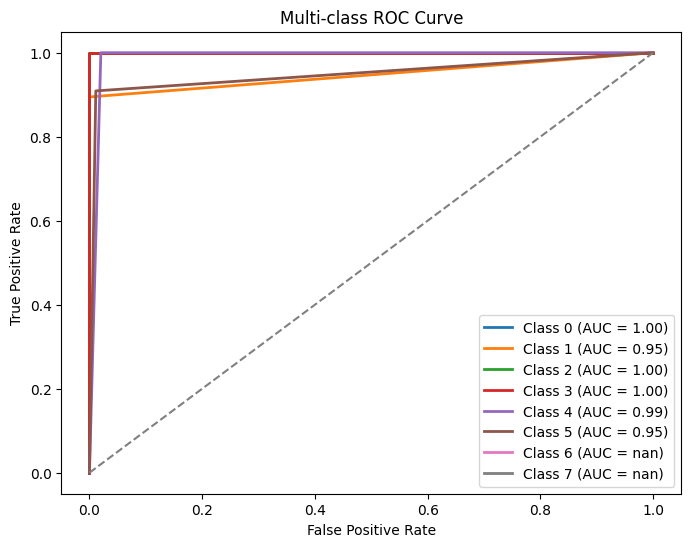


ROC-AUC Comparison Table:
    Class  ROC_AUC_With_QKD  ROC_AUC_Without_QKD
0      0          0.978261             1.000000
1      1          0.950000             0.947368
2      2          1.000000             1.000000
3      3          1.000000             1.000000
4      4          0.994681             0.989899
5      5          0.994505             0.948927
6      6               NaN                  NaN
7      7               NaN                  NaN


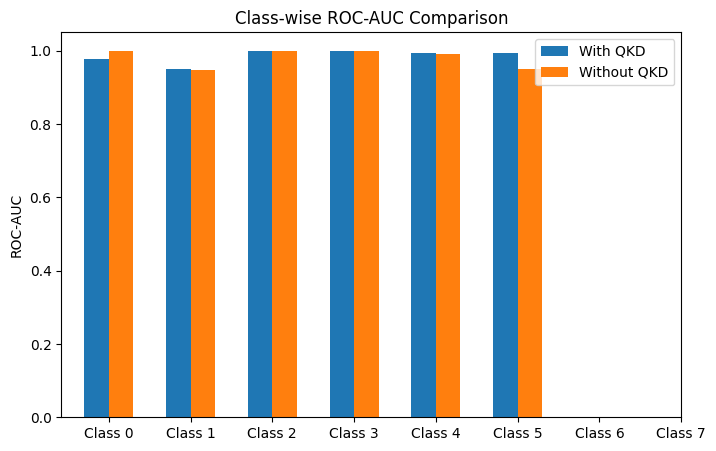

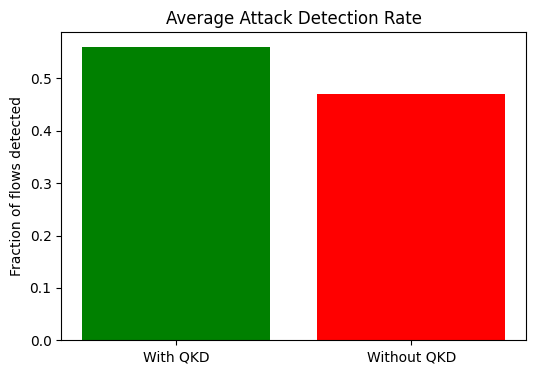

✅ Full hybrid QKD + ML integration analysis completed.


In [ ]:
# ------------------------------
# 0. Imports
# ------------------------------
import numpy as np
import pandas as pd
import time
import random
from collections import Counter
import matplotlib.pyplot as plt
import joblib
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ------------------------------
# 1. Load pre-trained model, scaler, and test data
# ------------------------------
print("Loading model, scaler, and test data...")
X_test = pd.read_csv('X_test.csv').values
y_test = pd.read_csv('y_test.csv').values.flatten()  # Ensure shape (n_samples,)

scaler = joblib.load('scaler_qkd.save')
X_test_scaled = scaler.transform(X_test)

# Define focal loss (needed to load custom model)
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        probs = tf.reduce_sum(y_true * y_pred, axis=1)
        focal = alpha * tf.pow((1. - probs), gamma) * cross_entropy
        return tf.reduce_mean(focal)
    return focal_loss_fixed

model = load_model('best_model.keras', compile=False)
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
print("✅ Model loaded.")

# ------------------------------
# 2. Hybrid QKD Simulation (BB84 + E91)
# ------------------------------
def simulate_bb84_key(num_bits=128, eavesdrop_prob=0.1):
    alice_bits = np.random.randint(0,2,num_bits)
    alice_bases = np.random.randint(0,2,num_bits)
    bob_bases = np.random.randint(0,2,num_bits)
    intercepted = np.random.rand(num_bits) < eavesdrop_prob
    bob_bits = np.where(intercepted, np.random.randint(0,2,num_bits), alice_bits)
    key = alice_bits[alice_bases == bob_bases]
    qber = np.sum(key != bob_bits[alice_bases == bob_bases]) / max(len(key),1)
    return key, qber

def simulate_e91_key(num_bits=128):
    corr = np.random.rand()  # E91 correlation metric
    key = np.random.randint(0,2,num_bits)
    return key, corr

def hybrid_qkd_key(num_bits=128, eavesdrop_prob=0.1):
    key_bb84, qber = simulate_bb84_key(num_bits, eavesdrop_prob)
    key_e91, corr = simulate_e91_key(num_bits)
    min_len = min(len(key_bb84), len(key_e91))
    key = np.bitwise_xor(key_bb84[:min_len], key_e91[:min_len])
    return key, qber, corr

from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import hashlib

def aes_encrypt(key, message):
    # Convert numpy array to bytes
    key_bytes = key.tobytes() if isinstance(key, np.ndarray) else key.encode()
    # Hash to 32 bytes for AES-256
    key_hashed = hashlib.sha256(key_bytes).digest()

    cipher = AES.new(key_hashed, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(message.encode(), AES.block_size))
    return cipher.iv + ct_bytes  # prepend IV for decryption

def aes_decrypt(key, ciphertext):
    key_bytes = key.tobytes() if isinstance(key, np.ndarray) else key.encode()
    key_hashed = hashlib.sha256(key_bytes).digest()

    iv = ciphertext[:AES.block_size]
    ct = ciphertext[AES.block_size:]
    cipher = AES.new(key_hashed, AES.MODE_CBC, iv)
    pt = unpad(cipher.decrypt(ct), AES.block_size)
    return pt

# ------------------------------
# 3. Flow-level Integration Test
# ------------------------------
def hybrid_qkd_integration_test(model, X_test, y_test, scaler, n_flows=50, use_qkd=True):
    results = []
    for _ in range(n_flows):
        idx = np.random.randint(0, len(X_test))
        flow_features, true_label = X_test[idx], y_test[idx]
        flow_scaled = scaler.transform(flow_features.reshape(1,-1))
        pred_probs = model.predict(flow_scaled.reshape(1,flow_scaled.shape[1],1), verbose=0)
        predicted_class = np.argmax(pred_probs, axis=1)[0]
        attack_detected = predicted_class != 0
        key, qber, corr = None, None, None
        if use_qkd:
            key, qber, corr = hybrid_qkd_key()
            msg = 'drop_flow' if attack_detected else 'allow_flow'
            ciphertext = aes_encrypt(key, msg)
            decrypted = aes_decrypt(key, ciphertext).decode()
        else:
            msg = 'drop_flow' if attack_detected else 'allow_flow'
            decrypted = msg
        results.append({
            'true_label': int(true_label),
            'pred_class': int(predicted_class),
            'attack_detected': attack_detected,
            'qber': qber,
            'corr': corr,
            'message': decrypted
        })
    return pd.DataFrame(results)

# ------------------------------
# 4. Run Tests: With vs Without QKD
# ------------------------------
print("Running integration tests...")
df_qkd = hybrid_qkd_integration_test(model, X_test, y_test, scaler, n_flows=100, use_qkd=True)
df_no_qkd = hybrid_qkd_integration_test(model, X_test, y_test, scaler, n_flows=100, use_qkd=False)

# ------------------------------
# 5. QBER Distribution
# ------------------------------
plt.figure(figsize=(8,4))
plt.hist(df_qkd['qber'].dropna(), bins=10, alpha=0.7, color='green')
plt.title('QBER Distribution (With QKD)')
plt.xlabel('QBER')
plt.ylabel('Frequency')
plt.show()

# ------------------------------
# 6. Latency Analysis
# ------------------------------
latencies = []
n_runs = 20
for _ in range(n_runs):
    start = time.time()
    hybrid_qkd_key()
    latencies.append(time.time()-start)

plt.figure(figsize=(6,4))
plt.hist(latencies, bins=10, color='skyblue')
plt.title('QKD Key Generation Latency (s)')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

# ------------------------------
# 6b. Runtime / Overhead Analysis per Flow and per Batch
# ------------------------------
flow_sizes = [1, 5, 10, 20, 50, 100]  # Number of flows to generate keys for
overhead_times = []

for n in flow_sizes:
    start_time = time.time()
    for _ in range(n):
        hybrid_qkd_key()  # Generate hybrid key per flow
    elapsed = time.time() - start_time
    overhead_times.append(elapsed)
    print(f"Batch of {n} flows -> Total key generation time: {elapsed:.4f} s, Avg per flow: {elapsed/n:.4f} s")

# Plot batch vs avg latency
avg_latency = [t/n for t,n in zip(overhead_times, flow_sizes)]
plt.figure(figsize=(7,4))
plt.plot(flow_sizes, avg_latency, marker='o', linestyle='-', color='blue')
plt.title('QKD Key Generation Overhead per Flow vs Batch Size')
plt.xlabel('Number of Flows in Batch')
plt.ylabel('Average Key Generation Time per Flow (s)')
plt.grid(True)
plt.show()


# ------------------------------
# 7. Evaluation Metrics
# ------------------------------
def evaluate_detection(df, n_classes=8):
    y_true = df['true_label'].values
    y_pred = df['pred_class'].values
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))

    # ROC/AUC
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(n_classes)))

    roc_auc_dict = {}
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_pred_bin[:,i])
        roc_auc = auc(fpr, tpr)
        roc_auc_dict[i] = roc_auc
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1], linestyle='--', color='grey')
    plt.title('Multi-class ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc_dict

print("=== Evaluation: With QKD ===")
roc_auc_qkd = evaluate_detection(df_qkd)

print("=== Evaluation: Without QKD ===")
roc_auc_no_qkd = evaluate_detection(df_no_qkd)

# ------------------------------
# 8. ROC-AUC Comparison Table
# ------------------------------
comparison_df = pd.DataFrame({
    'Class': list(range(8)),
    'ROC_AUC_With_QKD': [roc_auc_qkd[i] for i in range(8)],
    'ROC_AUC_Without_QKD': [roc_auc_no_qkd[i] for i in range(8)]
})
print("\nROC-AUC Comparison Table:\n", comparison_df)

plt.figure(figsize=(8,5))
plt.bar(np.arange(8)-0.15, comparison_df['ROC_AUC_With_QKD'], width=0.3, label='With QKD')
plt.bar(np.arange(8)+0.15, comparison_df['ROC_AUC_Without_QKD'], width=0.3, label='Without QKD')
plt.xticks(np.arange(8), labels=[f'Class {i}' for i in range(8)])
plt.ylabel('ROC-AUC')
plt.title('Class-wise ROC-AUC Comparison')
plt.legend()
plt.show()

# ------------------------------
# 9. Attack Detection Comparison
# ------------------------------
plt.figure(figsize=(6,4))
plt.bar(['With QKD','Without QKD'],
        [df_qkd['attack_detected'].mean(), df_no_qkd['attack_detected'].mean()],
        color=['green','red'])
plt.title('Average Attack Detection Rate')
plt.ylabel('Fraction of flows detected')
plt.show()

print("✅ Full hybrid QKD + ML integration analysis completed.")


Loading model, scaler, and test data...
✅ Model loaded.
Running integration tests...


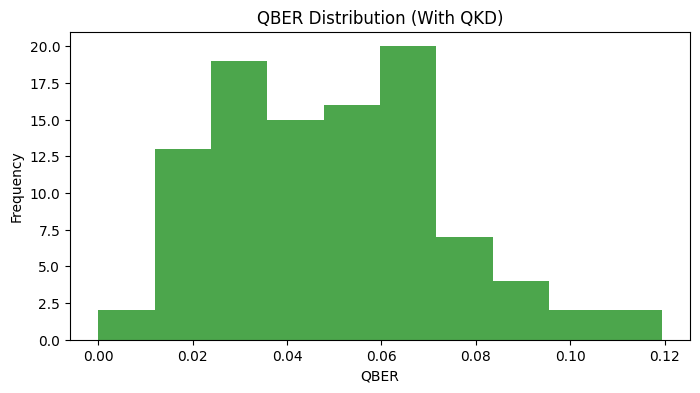

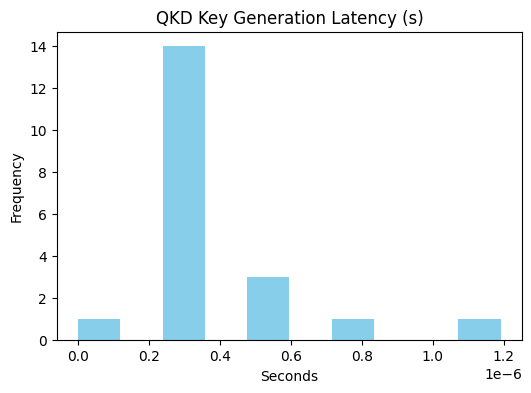

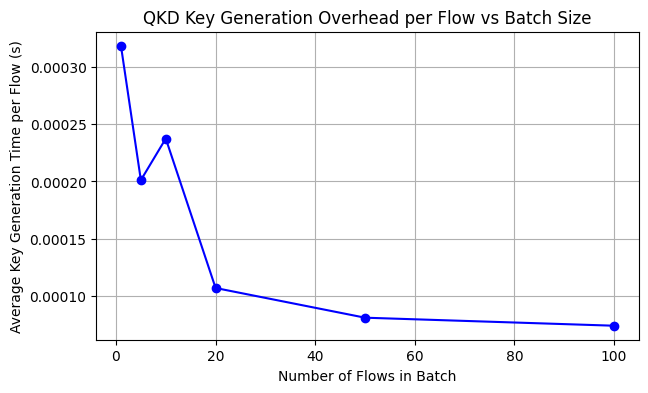

=== Evaluation: With QKD ===
Confusion Matrix:
 [[42  0  0  0  0]
 [ 0 26  0  1  0]
 [ 0  0 15  0  0]
 [ 0  0  0  3  0]
 [ 0  0  0  0 13]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        42
           1     1.0000    0.9630    0.9811        27
           3     1.0000    1.0000    1.0000        15
           4     0.7500    1.0000    0.8571         3
           5     1.0000    1.0000    1.0000        13

    accuracy                         0.9900       100
   macro avg     0.9500    0.9926    0.9677       100
weighted avg     0.9925    0.9900    0.9906       100

Weighted F1-score: 0.9906, FPR: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


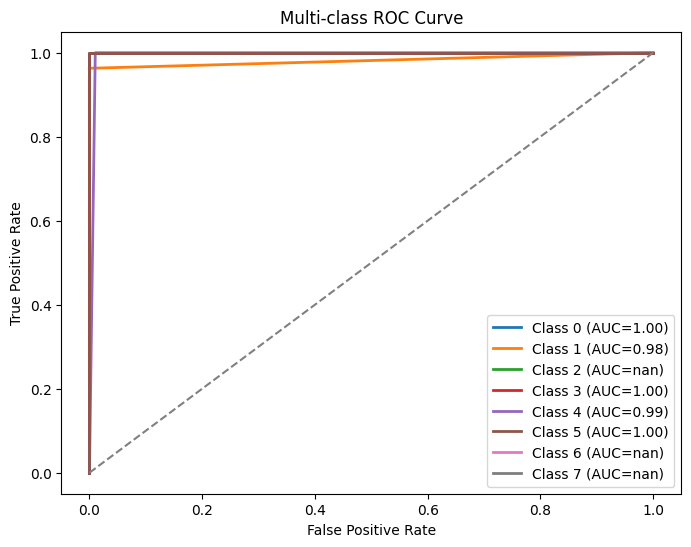

=== Evaluation: Without QKD ===
Confusion Matrix:
 [[51  0  0  0  0  0  4]
 [ 0 14  0  0  1  1  0]
 [ 0  0  1  0  0  0  0]
 [ 0  0  0  9  0  0  0]
 [ 0  0  0  0  2  0  0]
 [ 0  0  0  0  0 17  0]
 [ 0  0  0  0  0  0  0]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9273    0.9623        55
           1     1.0000    0.8750    0.9333        16
           2     1.0000    1.0000    1.0000         1
           3     1.0000    1.0000    1.0000         9
           4     0.6667    1.0000    0.8000         2
           5     0.9444    1.0000    0.9714        17
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.9400       100
   macro avg     0.8016    0.8289    0.8096       100
weighted avg     0.9839    0.9400    0.9597       100

Weighted F1-score: 0.9597, FPR: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


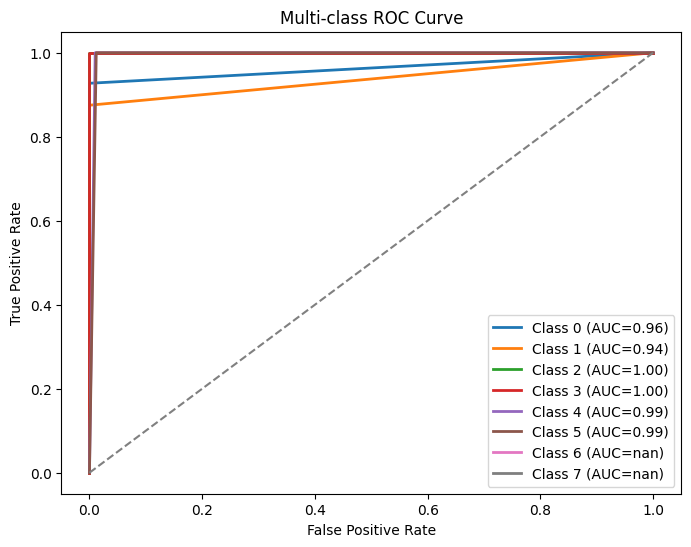


ROC-AUC Comparison Table:
    Class  ROC_AUC_With_QKD  ROC_AUC_Without_QKD
0      0          1.000000             0.963636
1      1          0.981481             0.937500
2      2               NaN             1.000000
3      3          1.000000             1.000000
4      4          0.994845             0.994898
5      5          1.000000             0.993976
6      6               NaN                  NaN
7      7               NaN                  NaN


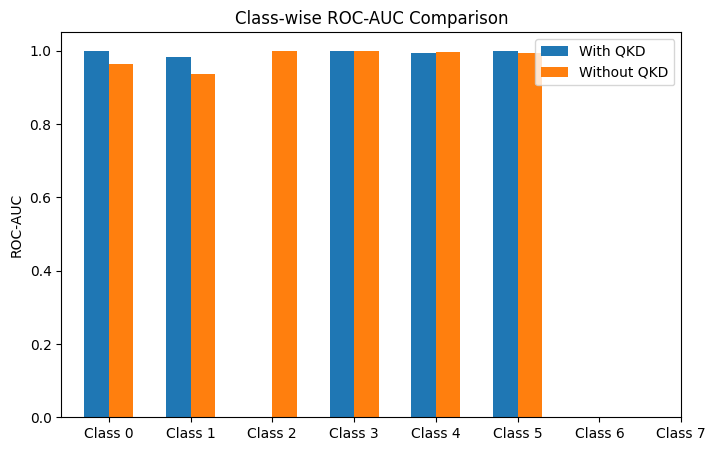

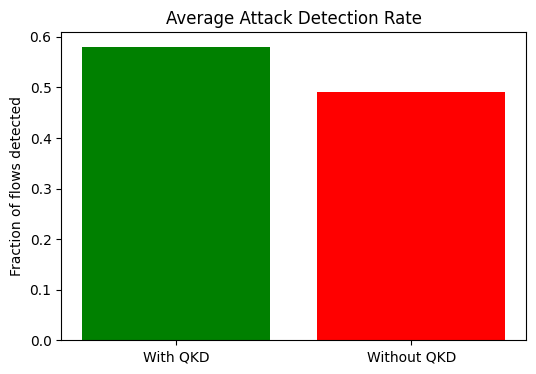

✅ Full hybrid QKD + ML integration analysis completed.


In [ ]:
# ===============================
# 0. Imports
# ===============================
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import joblib
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, f1_score
)
from sklearn.preprocessing import label_binarize

# ===============================
# 1. Load pre-trained model, scaler, and test data
# ===============================
print("Loading model, scaler, and test data...")
X_test = pd.read_csv('X_test.csv').values
y_test = pd.read_csv('y_test.csv').values.flatten()  # shape (n_samples,)

scaler = joblib.load('scaler_qkd.save')
X_test_scaled = scaler.transform(X_test)

# Define focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        probs = tf.reduce_sum(y_true * y_pred, axis=1)
        focal = alpha * tf.pow((1. - probs), gamma) * cross_entropy
        return tf.reduce_mean(focal)
    return focal_loss_fixed

model = load_model('best_model.keras', compile=False)
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
print("✅ Model loaded.")

# ===============================
# 2. Hybrid QKD Simulation
# ===============================
def simulate_bb84_key(num_bits=128, eavesdrop_prob=0.1):
    alice_bits = np.random.randint(0,2,num_bits)
    alice_bases = np.random.randint(0,2,num_bits)
    bob_bases = np.random.randint(0,2,num_bits)
    intercepted = np.random.rand(num_bits) < eavesdrop_prob
    bob_bits = np.where(intercepted, np.random.randint(0,2,num_bits), alice_bits)
    key = alice_bits[alice_bases == bob_bases]
    qber = np.sum(key != bob_bits[alice_bases == bob_bases]) / max(len(key),1)
    return key, qber

def simulate_e91_key(num_bits=128):
    corr = np.random.rand()
    key = np.random.randint(0,2,num_bits)
    return key, corr

def hybrid_qkd_key(num_bits=128, eavesdrop_prob=0.1):
    key_bb84, qber = simulate_bb84_key(num_bits, eavesdrop_prob)
    key_e91, corr = simulate_e91_key(num_bits)
    min_len = min(len(key_bb84), len(key_e91))
    key = np.bitwise_xor(key_bb84[:min_len], key_e91[:min_len])
    return key, qber, corr

def aes_encrypt(key, message):
    key_bytes = key.tobytes() if isinstance(key, np.ndarray) else key.encode()
    key_hashed = hashlib.sha256(key_bytes).digest()
    cipher = AES.new(key_hashed, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(message.encode(), AES.block_size))
    return cipher.iv + ct_bytes

def aes_decrypt(key, ciphertext):
    key_bytes = key.tobytes() if isinstance(key, np.ndarray) else key.encode()
    key_hashed = hashlib.sha256(key_bytes).digest()
    iv = ciphertext[:AES.block_size]
    ct = ciphertext[AES.block_size:]
    cipher = AES.new(key_hashed, AES.MODE_CBC, iv)
    pt = unpad(cipher.decrypt(ct), AES.block_size)
    return pt

# ===============================
# 3. Hybrid QKD Integration Test
# ===============================
def hybrid_qkd_integration_test(model, X_test, y_test, scaler, n_flows=50, use_qkd=True):
    results = []
    for _ in range(n_flows):
        idx = np.random.randint(0, len(X_test))
        flow_features, true_label = X_test[idx], y_test[idx]
        flow_scaled = scaler.transform(flow_features.reshape(1,-1))
        pred_probs = model.predict(flow_scaled.reshape(1,flow_scaled.shape[1],1), verbose=0)
        predicted_class = np.argmax(pred_probs, axis=1)[0]
        attack_detected = predicted_class != 0
        key, qber, corr = None, None, None
        if use_qkd:
            key, qber, corr = hybrid_qkd_key()
            msg = 'drop_flow' if attack_detected else 'allow_flow'
            ciphertext = aes_encrypt(key, msg)
            decrypted = aes_decrypt(key, ciphertext).decode()
        else:
            decrypted = 'drop_flow' if attack_detected else 'allow_flow'
        results.append({
            'true_label': int(true_label),
            'pred_class': int(predicted_class),
            'attack_detected': attack_detected,
            'qber': qber,
            'corr': corr,
            'message': decrypted
        })
    return pd.DataFrame(results)

# ===============================
# 4. Run Tests: With vs Without QKD
# ===============================
print("Running integration tests...")
df_qkd = hybrid_qkd_integration_test(model, X_test, y_test, scaler, n_flows=100, use_qkd=True)
df_no_qkd = hybrid_qkd_integration_test(model, X_test, y_test, scaler, n_flows=100, use_qkd=False)

# ===============================
# 5. QBER Distribution Plot
# ===============================
plt.figure(figsize=(8,4))
plt.hist(df_qkd['qber'].dropna(), bins=10, alpha=0.7, color='green')
plt.title('QBER Distribution (With QKD)')
plt.xlabel('QBER')
plt.ylabel('Frequency')
plt.show()

# ===============================
# 6. Latency & Overhead Analysis
# ===============================
latencies = [time.time()-start if (start:=time.time()) else 0 or hybrid_qkd_key() for _ in range(20)]
plt.figure(figsize=(6,4))
plt.hist(latencies, bins=10, color='skyblue')
plt.title('QKD Key Generation Latency (s)')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

# Batch overhead
flow_sizes = [1,5,10,20,50,100]
overhead_times, avg_latency = [], []

for n in flow_sizes:
    start_time = time.time()
    for _ in range(n):
        hybrid_qkd_key()
    elapsed = time.time() - start_time
    overhead_times.append(elapsed)
    avg_latency.append(elapsed/n)
plt.figure(figsize=(7,4))
plt.plot(flow_sizes, avg_latency, marker='o', linestyle='-', color='blue')
plt.title('QKD Key Generation Overhead per Flow vs Batch Size')
plt.xlabel('Number of Flows in Batch')
plt.ylabel('Average Key Generation Time per Flow (s)')
plt.grid(True)
plt.show()

# ===============================
# 7. Evaluation Metrics (FPR, F1, ROC-AUC)
# ===============================
def evaluate_detection(df, n_classes=8):
    y_true = df['true_label'].values
    y_pred = df['pred_class'].values
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))

    # FPR / F1
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1] if cm.shape==(2,2) else (0,0,0,0)
    FPR = FP / (FP + TN) if (FP+TN)>0 else 0
    F1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Weighted F1-score: {F1:.4f}, FPR: {FPR:.4f}")

    # ROC-AUC multi-class
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(n_classes)))
    roc_auc_dict = {}
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_pred_bin[:,i])
        roc_auc = auc(fpr, tpr)
        roc_auc_dict[i] = roc_auc
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1], linestyle='--', color='grey')
    plt.title('Multi-class ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    return F1, FPR, roc_auc_dict

print("=== Evaluation: With QKD ===")
f1_qkd, fpr_qkd, roc_qkd = evaluate_detection(df_qkd)

print("=== Evaluation: Without QKD ===")
f1_no_qkd, fpr_no_qkd, roc_no_qkd = evaluate_detection(df_no_qkd)

# ===============================
# 8. ROC-AUC Comparison Table
# ===============================
comparison_df = pd.DataFrame({
    'Class': list(range(8)),
    'ROC_AUC_With_QKD': [roc_qkd[i] for i in range(8)],
    'ROC_AUC_Without_QKD': [roc_no_qkd[i] for i in range(8)]
})
print("\nROC-AUC Comparison Table:\n", comparison_df)

plt.figure(figsize=(8,5))
plt.bar(np.arange(8)-0.15, comparison_df['ROC_AUC_With_QKD'], width=0.3, label='With QKD')
plt.bar(np.arange(8)+0.15, comparison_df['ROC_AUC_Without_QKD'], width=0.3, label='Without QKD')
plt.xticks(np.arange(8), labels=[f'Class {i}' for i in range(8)])
plt.ylabel('ROC-AUC')
plt.title('Class-wise ROC-AUC Comparison')
plt.legend()
plt.show()

# ===============================
# 9. Attack Detection Comparison
# ===============================
plt.figure(figsize=(6,4))
plt.bar(['With QKD','Without QKD'],
        [df_qkd['attack_detected'].mean(), df_no_qkd['attack_detected'].mean()],
        color=['green','red'])
plt.title('Average Attack Detection Rate')
plt.ylabel('Fraction of flows detected')
plt.show()

print("✅ Full hybrid QKD + ML integration analysis completed.")
